# SDCND Advanced Lane Finding

## Camera Calibration 

In [2]:
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt

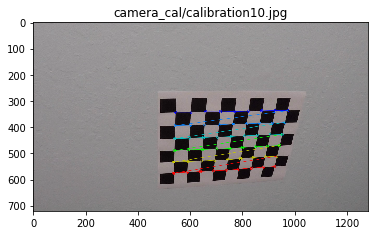

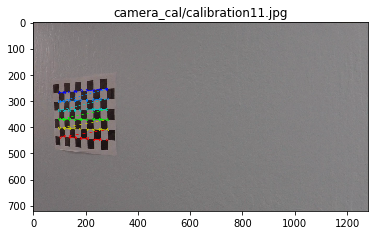

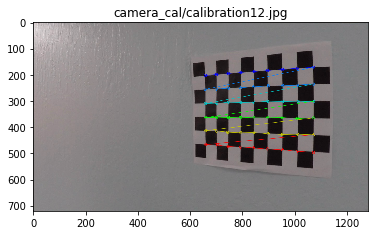

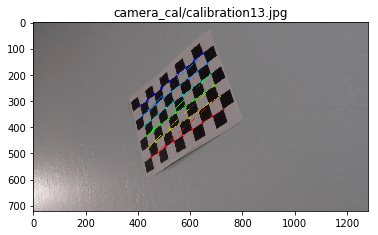

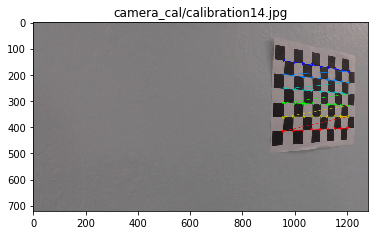

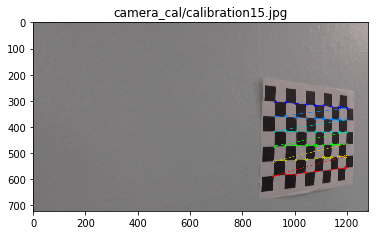

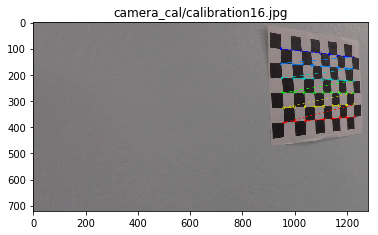

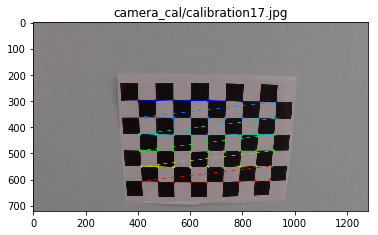

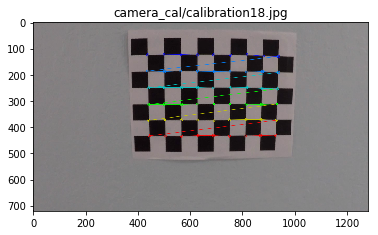

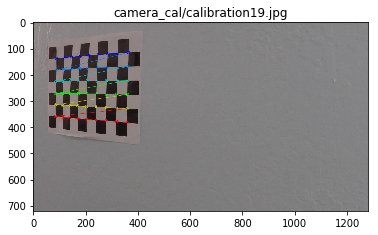

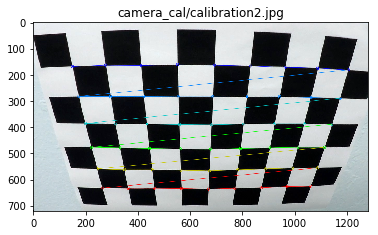

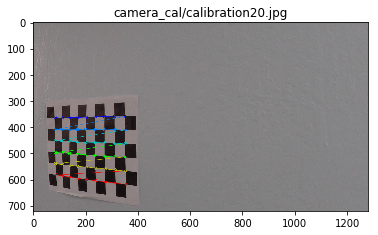

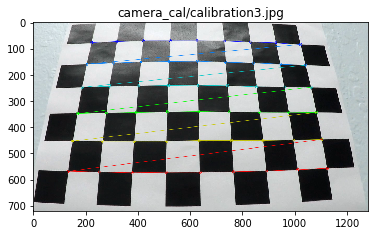

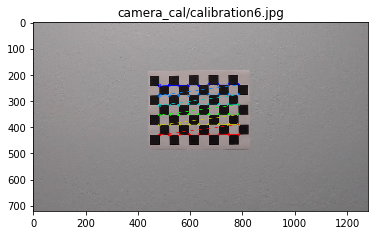

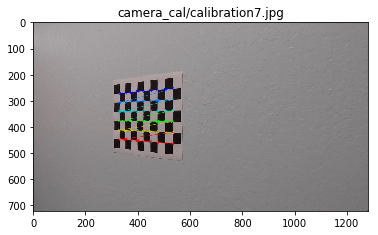

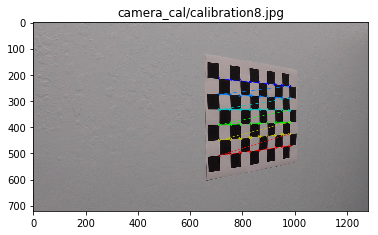

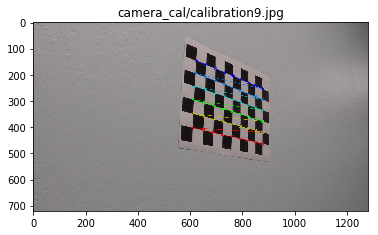

Done


In [24]:
# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2)
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d points in real world space
imgpoints = [] # 2d points in image plane.
# Make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')
# Step through the list and search for chessboard corners
for image in images:
    img = cv2.imread(image)
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6),None)
    # If found, add object points, image points
    if ret == True:
        objpoints.append(objp)
        imgpoints.append(corners)
        # Draw and display the corners
        img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        plt.imshow(img)
        plt.title(image)
        plt.show()
# Optain camera matrix, distortion coefficients, rotation and translation vectors from object points and image points
ret, mtx, dist, rvecs, tvecs = cv2.calibrateCamera(objpoints, imgpoints, gray.shape[::-1], None, None)
print('Done')
## [reference](http://docs.opencv.org/3.1.0/dc/dbb/tutorial_py_calibration.html)

## Obtained CameraMatrix and DistortionCoefficients

In [5]:
mtx = np.array([[  1.15396093e+03,   0.00000000e+00,   6.69705357e+02],
       [  0.00000000e+00,   1.14802496e+03,   3.85656234e+02],
       [  0.00000000e+00,   0.00000000e+00,   1.00000000e+00]])
dist = np.array([[ -2.41017956e-01,  -5.30721173e-02,  -1.15810355e-03,
         -1.28318856e-04,   2.67125290e-02]])

## Save Undistorted Images for Writeup

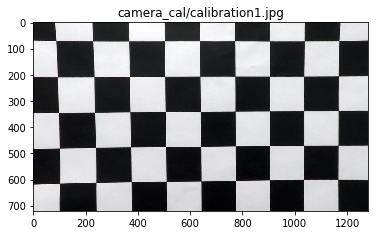

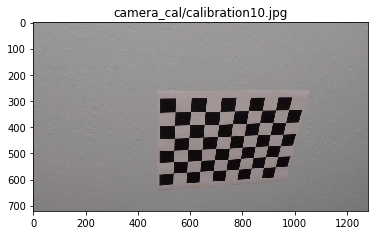

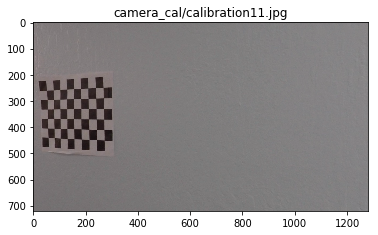

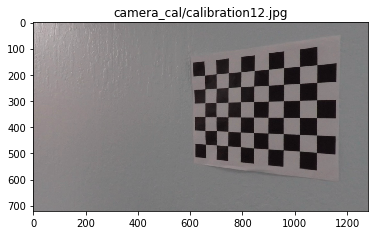

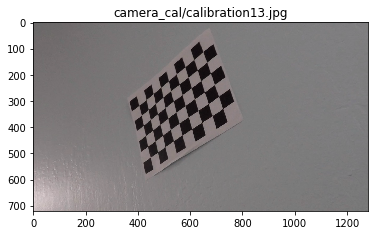

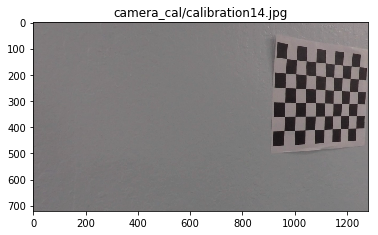

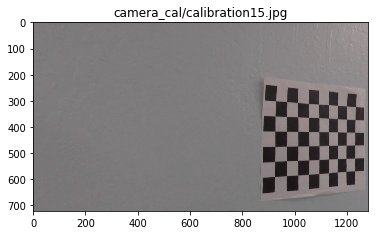

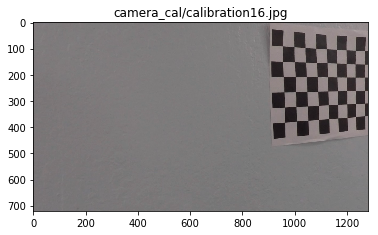

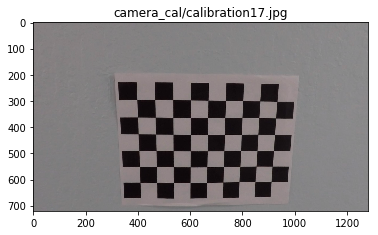

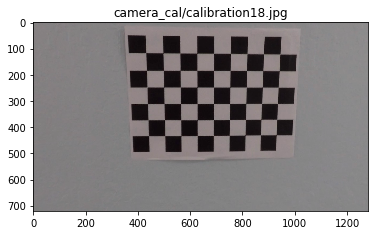

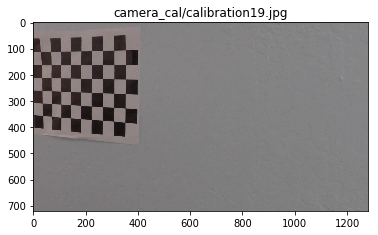

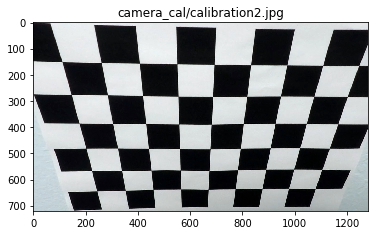

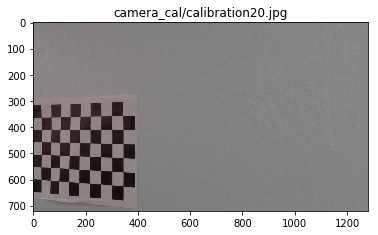

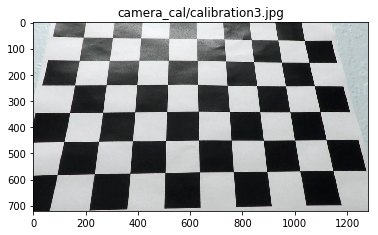

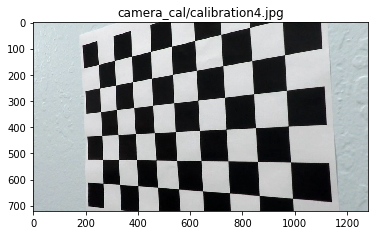

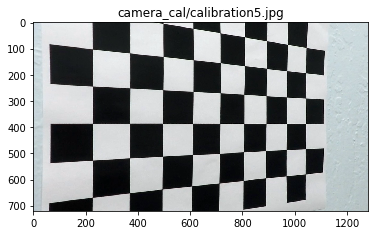

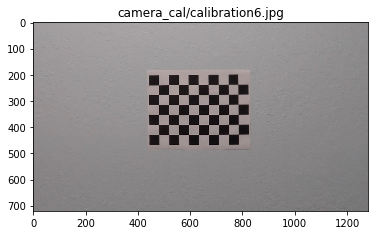

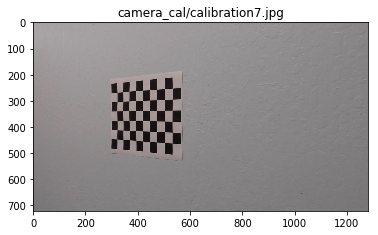

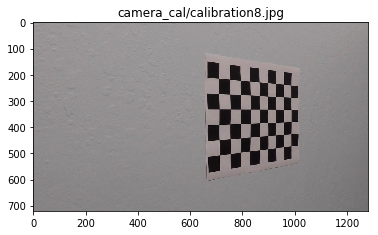

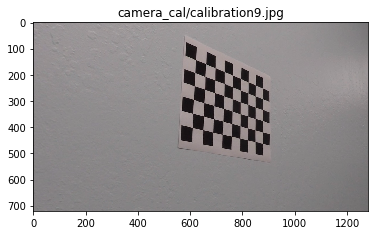

In [25]:
for image in images:
    img = cv2.imread(image)
    dst = cv2.undistort(img, mtx, dist, None, mtx)
    plt.imshow(dst)
    plt.title(image)
    plt.show()
    cv2.imwrite("camera_cal_undistorted/"+image.split('/')[-1]+".jpg",dst)

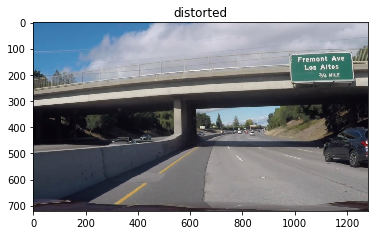

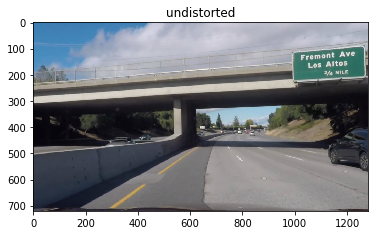

In [9]:
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')
image = cv2.imread(images[2])
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.title('distorted')
plt.show()
image = cv2.undistort(image, mtx, dist, None, mtx)
plt.imshow(cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
plt.title('undistorted')
plt.show()

## Pipeline for Test Images

In [42]:
# Make a list of calibration images
images = glob.glob('test_images/*.jpg')

## HLS Color Threshold

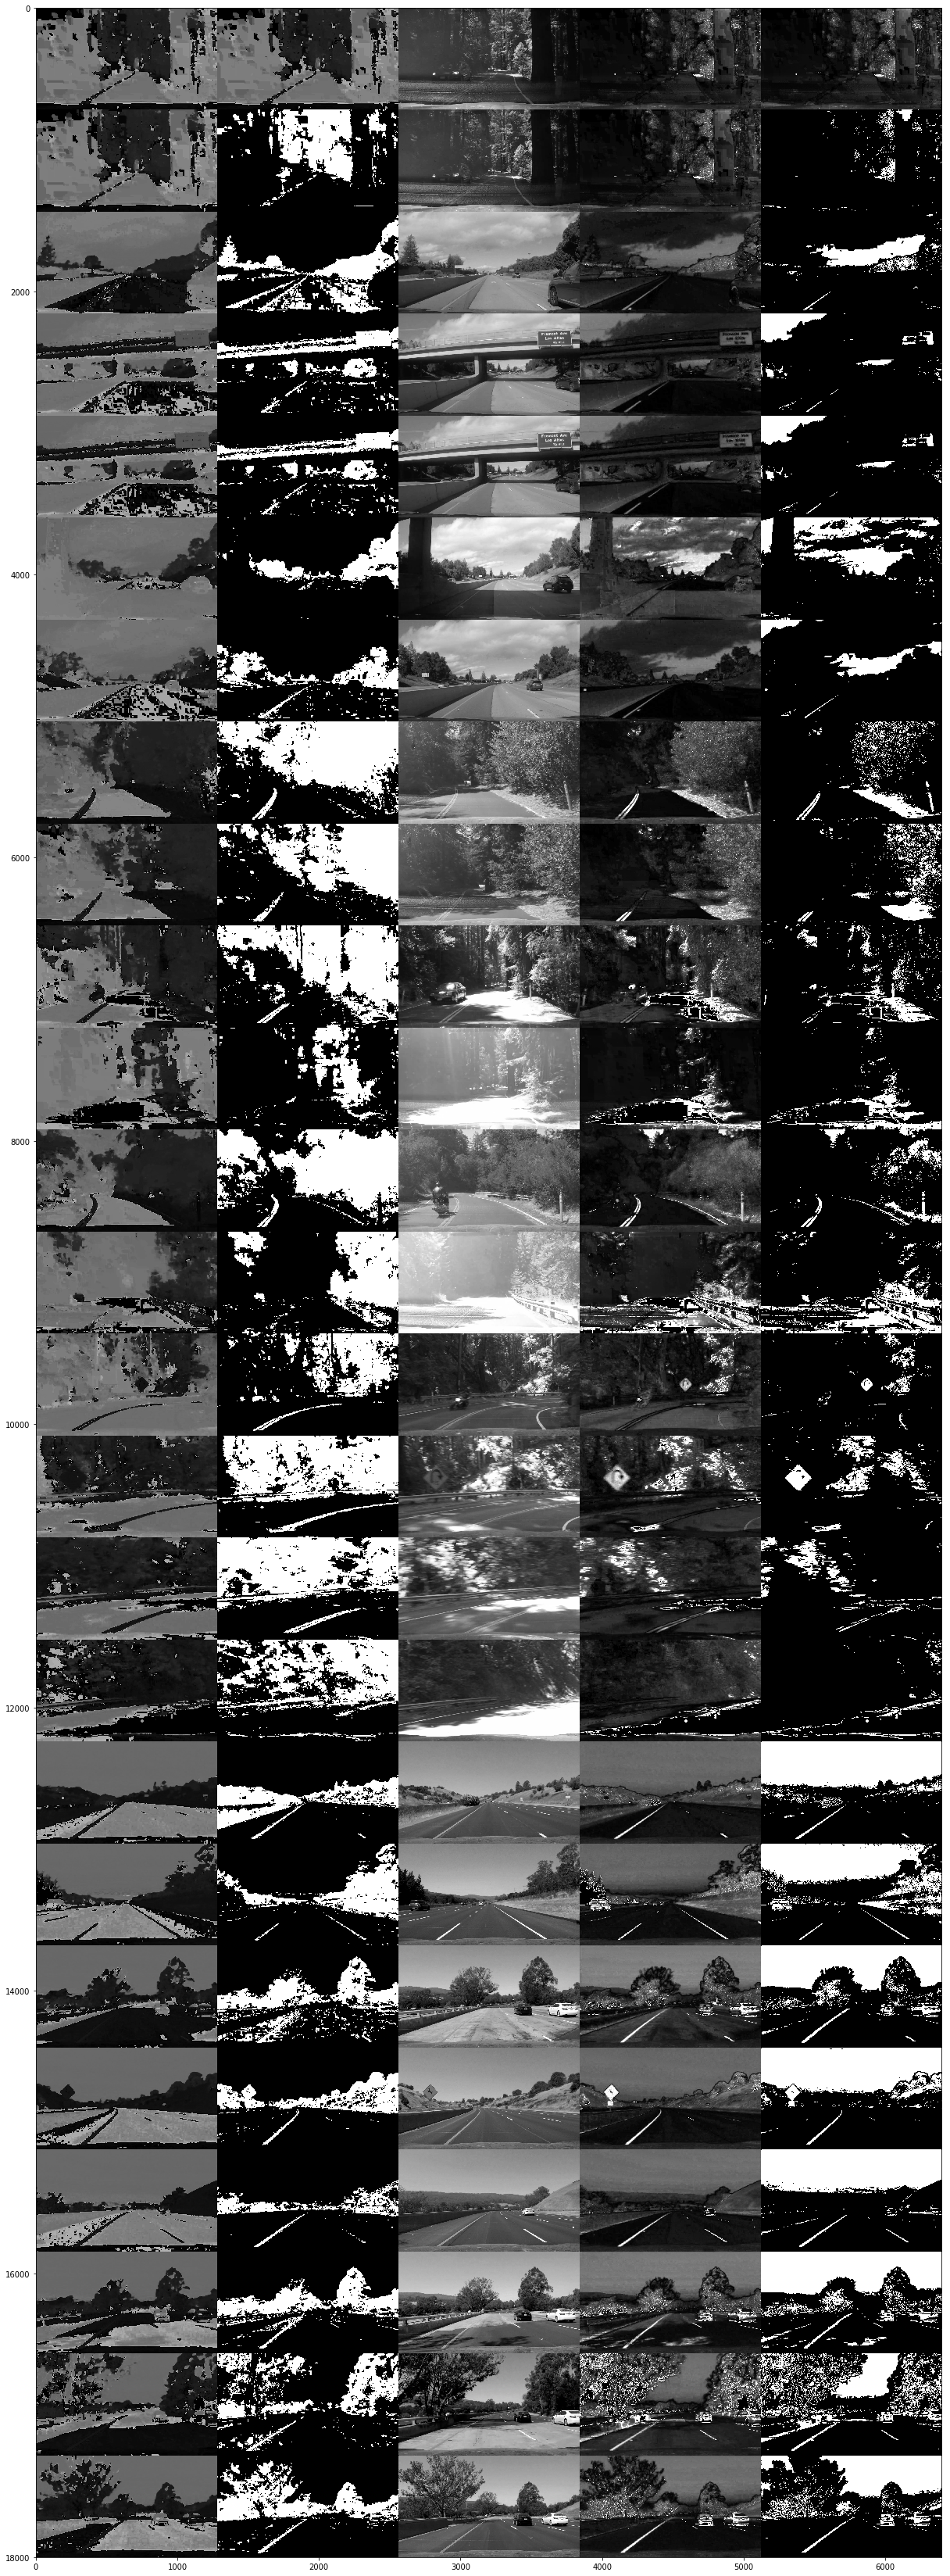

In [49]:
def binary_color_thres(img):
    hls = cv2.cvtColor(img,cv2.COLOR_BGR2HLS)
    H, L, S = cv2.split(hls)
    # thresh for S
    thresh = (90, 255)
    binaryS = np.zeros_like(S)
    binaryS[(S > thresh[0]) & (S <= thresh[1])] = 255
    # threash for H
    thresh = (15, 90)
    binaryH = np.zeros_like(H)
    binaryH[(H > thresh[0]) & (H <= thresh[1])] = 255
    return S, L, H, binaryS, binaryH

image = images[0]
img = cv2.imread(image)
hls = cv2.cvtColor(img, cv2.COLOR_BGR2HLS)
H, L, S = cv2.split(hls)
HLS = np.concatenate([H,H,L,S,S],axis=1)
for image in images:
    img = cv2.imread(image)
    S, L, H, binaryS, binaryH = binary_color_thres(img)
    HLS = np.concatenate([HLS,np.concatenate([H,binaryH,L,S,binaryS],axis=1)],axis=0)
fig, ax = plt.subplots(nrows=1, ncols=1 ,figsize=(30,60))
ax.imshow(HLS,cmap='gray')
plt.show()

## Sobel Threshold

In [ ]:
def abs_sobel_thresh(img, orient='x', thresh_min=0, thresh_max=255):
    # Apply x or y gradient with the OpenCV Sobel() function
    # and take the absolute value
    if orient == 'x':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 1, 0))
    if orient == 'y':
        abs_sobel = np.absolute(cv2.Sobel(img, cv2.CV_64F, 0, 1))
    # Rescale back to 8 bit integer
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Create a copy and apply the threshold
    grad_binary = np.zeros_like(scaled_sobel)
    # Here I'm using inclusive (>=, <=) thresholds, but exclusive is ok too
    grad_binary[(scaled_sobel >= thresh_min) & (scaled_sobel <= thresh_max)] = 255
    # Return the result
    return grad_binary

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Take both Sobel x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Calculate the gradient magnitude
    gradmag = np.sqrt(sobelx**2 + sobely**2)
    # Rescale to 8 bit
    scale_factor = np.max(gradmag)/255 
    gradmag = (gradmag/scale_factor).astype(np.uint8) 
    # Create a binary image of ones where threshold is met, zeros otherwise
    mag_binary = np.zeros_like(gradmag)
    mag_binary[(gradmag >= mag_thresh[0]) & (gradmag <= mag_thresh[1])] = 255
    # Return the binary image
    return mag_binary

def dir_threshold(img, sobel_kernel=11, thresh=(0, np.pi/2)):
    # Calculate the x and y gradients
    sobelx = cv2.Sobel(img, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(img, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    # Take the absolute value of the gradient direction, 
    # apply a threshold, and create a binary image result
    absgraddir = np.arctan2(np.absolute(sobely), np.absolute(sobelx))
    dir_binary =  np.zeros_like(absgraddir)
    dir_binary[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 255
    # Return the binary image
    return dir_binary

img = cv2.imread(images[0])
img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
ALL = np.concatenate([img,img,img,img],axis=1)
for image in images:
    img = cv2.imread(image)
    # Grayscale
    img = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    # Apply each of the thresholding functions
    #gradx = abs_sobel_thresh(img, orient='x',thresh_min=10, thresh_max=255)
    #grady = abs_sobel_thresh(img, orient='y',thresh_min=10, thresh_max=255)
    mag_binary = mag_thresh(img, sobel_kernel=17, mag_thresh=(50, 255))
    dir_binary_P = dir_threshold(img, sobel_kernel=27, thresh=(np.pi*30/180, np.pi*75/180)) 
    morph_dir_binary_P = cv2.morphologyEx(dir_binary_P, cv2.MORPH_OPEN, kernel=(5,5))
    ALL = np.concatenate([ALL,np.concatenate([img,mag_binary,dir_binary_P,morph_dir_binary_P],axis=1)],axis=0)

fig, ax = plt.subplots(nrows=1, ncols=1 ,figsize=(30,60))
ax.imshow(ALL,cmap='gray')
plt.show()
    #combined = np.zeros_like(dir_binary)
    #combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1


## Perspective Transform

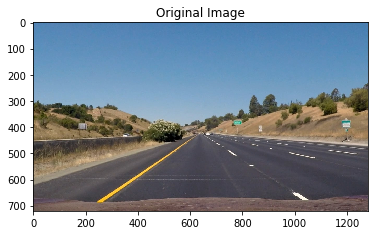

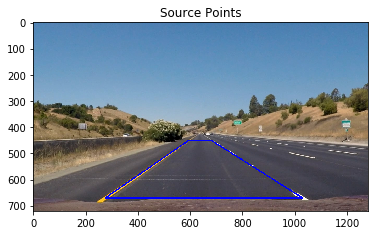

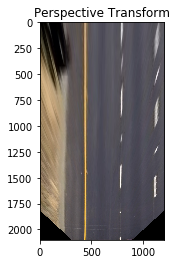

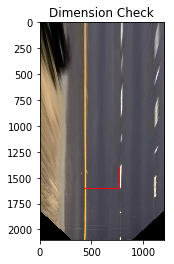

In [38]:
straight = cv2.imread('test_images/straight_lines1.jpg')
straight = cv2.cvtColor(straight, cv2.COLOR_BGR2RGB)
# original image size
img_size = (1280,720)
# define size of warped image
warped_img_size = (1200,2100)

src = np.float32([[595,450],[680,450],[1030,670],[275,670]])
# crop the top half of the image
dst = np.float32([[430,0],[770,0],[770,warped_img_size[1]],[430,warped_img_size[1]]])
# using cv2.polylines to show the source points defined above
vertices = np.int32([[595,450],[680,450],[1030,670],[275,670],[595,450]])
source_points = np.copy(straight)   
cv2.polylines(source_points, [vertices],0,[0,0,255],3)
def perspective_transform(image,img_size=warped_img_size):
    M = cv2.getPerspectiveTransform(src, dst)
    Minv = cv2.getPerspectiveTransform(dst, src)
    return cv2.warpPerspective(image, M, img_size, flags=cv2.INTER_LINEAR)
warped = perspective_transform(straight)
plt.imshow(straight)
plt.title('Original Image')
plt.show()
plt.imshow(source_points)
plt.title('Source Points')
plt.show()
plt.imshow(warped)
plt.title('Perspective Transform')
plt.show()
# using cv2.polylines to show the source points defined above
vertices = np.int32([[750,1400],[750,1600],[430,1600]])
warped_copy = np.copy(warped)   
cv2.polylines(warped_copy, [vertices],0,[255,0,0],10)
plt.imshow(warped_copy)
plt.title('Dimension Check')
plt.show()

## Process Image (undistort)->(threshold)->(perspective transform)

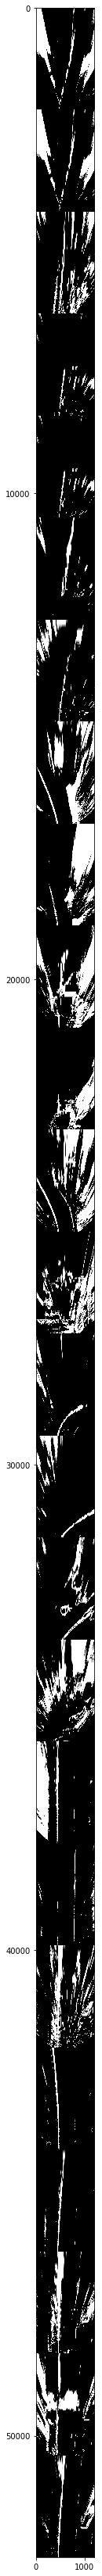

In [15]:
def process_image(image):
    # undistort image 
    img = cv2.undistort(image, mtx, dist, None, mtx)
    # color threshold
    S, L, H, binaryS, binaryH = binary_color_thres(img)
    # add S threshold and H threshold together
    img = cv2.bitwise_or(binaryS,binaryH)
    # perspective transform
    img = perspective_transform(img)
    return img

proc = process_image(cv2.imread(images[0]))
for im in images:
    img = cv2.imread(im)
    img = process_image(img)
    proc = np.concatenate([proc,img],axis=0)
fig, ax = plt.subplots(nrows=1, ncols=1 ,figsize=(40,60))
ax.imshow(proc,cmap='gray')
plt.show()

## Convoluton Lane Line Search from a Layered Image Histogram 

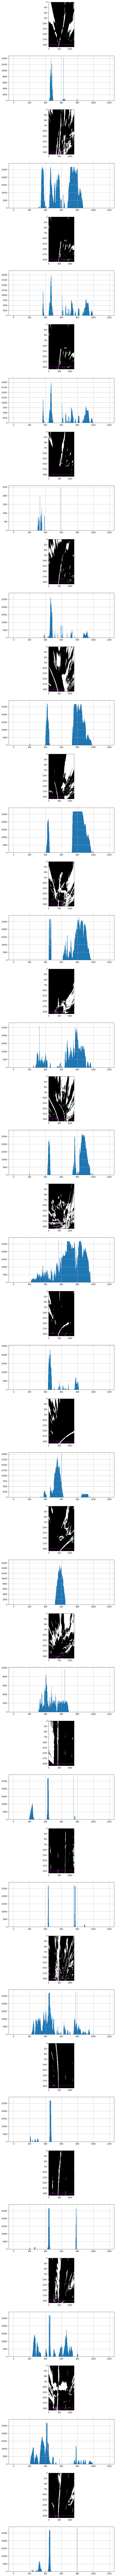

In [14]:
# find peaks in a histogram
def HistogramConvolution(binary_warped_layer, left_center, right_center, margin, conv_window_wid):
    # Set minimum number of pixels found to recenter window
    minpix = 50
    # define convolution kernel
    conv_window = np.ones(conv_window_wid)
    # get histogram of binary image along vertical axis
    histogram = np.sum(binary_warped_layer,axis=0)
    # histogram of left
    hist_left = histogram[(left_center-margin):(left_center+margin)]
    # histogram of right
    hist_right = histogram[(right_center-margin):right_center+margin]
    if len(hist_left)==0:
        hist_left = [0]
    elif max(hist_left)<minpix:
        hist_left[:]=0
    if len(hist_right)==0:
        hist_right = [0]
    elif max(hist_right)<minpix:
        hist_right[:]=0
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    arg_left = np.argmax(np.convolve(conv_window,hist_left))
    leftx_base = int(arg_left-conv_window_wid/2+(left_center-margin))
    arg_right = np.argmax(np.convolve(conv_window,hist_right))
    rightx_base = int(arg_right-conv_window_wid/2+(right_center-margin))
    # approximate distance between left and right lane lines
    lane_width = int(len(histogram)*0.29)
    # in case any convolution found
    if arg_left == 0 & arg_right == 0:
        leftx_base = left_center    # assign previously defined center
        rightx_base = right_center  # assign previously defined center
    elif arg_left == 0:
        leftx_base = rightx_base-lane_width   # if left center not found, assign (found right center) - (estimated lane width)
    elif arg_right == 0:
        rightx_base = leftx_base+lane_width   # if right center not found, assign (found left center) + (estimated lane width)
    return leftx_base, rightx_base, histogram

### plot histogram
def histogramPlot(inputs, datatype, axnum):
    ax[axnum].bar(range(histogram.shape[0]), inputs, width=1, align='center')
    ax[axnum].grid()

fig, ax = plt.subplots(len(images)*2,1,figsize=(10,250))
i = 0
for image in images:
    img = cv2.imread(image)
    img = process_image(img)
    y_line = 19/20
    binary_warped_layer = img[np.uint16(img.shape[0]*y_line):,:]
    leftx_base, rightx_base, histogram = HistogramConvolution(binary_warped_layer,left_center=450,right_center=750,margin=150,conv_window_wid=50)
    histogram[leftx_base] = max(histogram)+500
    histogram[rightx_base] = max(histogram)+500
    img_copy = np.dstack((np.copy(img), np.copy(img), np.copy(img)))
    cv2.line(img_copy, (0,np.uint16(img.shape[0]*y_line)), (img.shape[1],np.uint16(img.shape[0]*y_line)),(255,0,255),5)    
    ax[i].imshow(img_copy)
    i = i+1
    histogramPlot(histogram, 'image', i)
    i = i+1
plt.show()

## Search Lane Lines from Bottom of the Image

In [16]:
def find_window_center(warped_image, conv_window_wid, window_height, margin, nlayers):
    window_center = [] # list of window center of each layer
    left_center = 450 # initial approximate center
    right_center = 750 # initial approximate center
    for layer in range(0,nlayers):
        # define layer
        layer_im = warped_image[(warped_image.shape[0]-window_height*(layer+1)):(warped_image.shape[0]-window_height*(layer)),:]
        # find left and right center by convolution
        leftx_center, rightx_center, histogram = HistogramConvolution(layer_im,left_center,right_center,margin,conv_window_wid)
        # store center location
        window_center.append((leftx_center,rightx_center))
        # update the next estimated center 
        if layer==0:
            left_center = leftx_center
            right_center = rightx_center
        else:
            delta_left = np.int16((window_center[layer][0]-window_center[layer-1][0])/2)
            left_center = leftx_center+delta_left
            delta_right = np.int16((window_center[layer][1]-window_center[layer-1][1])/2)
            right_center = rightx_center+delta_right
        # update margin
        margin = 70
        # end the loop if window reaches the left or right ends of the image
        if left_center<margin+10:
            break
        if right_center>(layer_im.shape[1]-(margin+10)):
            break 
    return window_center


## For Visualization 

In [17]:
def drawContours(warped, Lfitx, Rfitx, color):
    # Define y values
    y = np.linspace(warped.shape[0],0,int(warped.shape[0]/2))
    # Create an image to draw the lines on 
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([Lfitx, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([Rfitx, y])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    return cv2.drawContours(warped, np.int_([pts]), 0, color=color, thickness=3) 

def window_mask(width, height, img_ref, center,level):
    mask = np.zeros_like(img_ref)
    mask[int(img_ref.shape[0]-(level+1)*height):int(img_ref.shape[0]-level*height),max(0,int(center-width/2)):min(int(center+width/2),img_ref.shape[1])] = 1
    return mask


## Find Lane Lines

In [40]:
# take warped image and find lane lines, output warped image with lane lines
def find_lane_lines(warped):
    left_fitx = []
    right_fitx = []
    curverad = [] 
    offset = [] 
    conv_window_wid = 50   # window settings
    nlayers = 30           # Choose the number of layers
    margin = 100           # How much to slide left and right for searching
    window_height = np.int(warped.shape[0]/nlayers)  # set height of window
    window_center = find_window_center(warped, conv_window_wid, window_height, margin, nlayers)
    # If we found any window centers
    if len(window_center) > 0:
        # Points used to draw all the left and right windows
        l_points = np.zeros_like(warped)
        r_points = np.zeros_like(warped)
        # Go through each level and draw the windows 
        for layer in range(0,len(window_center)):
            # Window_mask is a function to draw window areas
            l_mask = window_mask(conv_window_wid,window_height,warped,window_center[layer][0],layer)
            r_mask = window_mask(conv_window_wid,window_height,warped,window_center[layer][1],layer)
            # Add graphic points from window mask here to total pixels found 
            l_points[(l_points == 255) | ((l_mask == 1) ) ] = 255
            r_points[(r_points == 255) | ((r_mask == 1) ) ] = 255
            nonzerol = l_points.nonzero()
            nonzeroly = np.array(nonzerol[0])
            nonzerolx = np.array(nonzerol[1])
            nonzeror = r_points.nonzero()
            nonzerory = np.array(nonzeror[0])
            nonzerorx = np.array(nonzeror[1])    
            # poly fit left and right lanes and obtain sum of coefficients of variance
            coeffsL, covl = np.polyfit(nonzeroly, nonzerolx, 2, cov=True)
            errorl = np.sum(np.sqrt(np.diag(covl)))  
            coeffsR, covr = np.polyfit(nonzerory, nonzerorx, 2, cov=True)
            errorr = np.sum(np.sqrt(np.diag(covr)))  
            if layer > 15:
                break
        # Draw the results
        template = np.array(r_points+l_points,np.uint8) # add both left and right window pixels together
        zero_channel = np.zeros_like(template) # create a zero color channel
        template = np.array(cv2.merge((zero_channel,template,zero_channel)),np.uint8) # make window pixels green
        warpage = np.array(cv2.merge((warped,warped,warped)),np.uint8) # making the original road pixels 3 color channels
        warped_out = cv2.addWeighted(warpage, 1, template, 0.5, 0.0) # overlay the orignal road image with window results
    # If no window centers found, just display orginal road image
    else:
        warped_out = np.array(cv2.merge((warped,warped,warped)),np.uint8)
        coeffsL = None
        coeffsR = None
        errorl = None
        errorr = None
        nonzeroly = None
        nonzerolx = None
        nonzerory = None
        nonzerorx = None
        
#     # Display the final results
#     plt.imshow(warped_out)
#     plt.plot(left_fitx, y, color='yellow',linewidth=2.0)
#     plt.plot(right_fitx, y, color='blue',linewidth=2.0)
#     plt.xlim(0, warped.shape[1])
#     plt.ylim(warped.shape[0], 0)
#     plt.title('window fitting results')
#     plt.show()        
    
    return warped_out, coeffsL, coeffsR, errorl, errorr, nonzeroly, nonzerolx, nonzerory, nonzerorx


## Find Lane Lines from Previously Found Lane Lines

In [26]:
def find_lane_lines_from_Previous(warped,left_fit,right_fit):
    warped_OUT,CoeffsL,CoeffsR,errorL,errorR,leftY,leftX,rightY,rightX = [],[],[],[],[],[],[],[],[]
    # Define y values
    y = np.linspace(warped.shape[0],0,int(warped.shape[0]/2))
    # Assume you now have a new warped binary image 
    # from the next frame of video (also called "binary_warped")
    # It's now much easier to find line pixels!
    nonzero = warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    margin = 70
    left_lane_inds = ((nonzerox > (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] - margin))
                      & (nonzerox < (left_fit[0]*(nonzeroy**2) + left_fit[1]*nonzeroy + left_fit[2] + margin))) 
    right_lane_inds = ((nonzerox > (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] - margin))
                       & (nonzerox < (right_fit[0]*(nonzeroy**2) + right_fit[1]*nonzeroy + right_fit[2] + margin)))  
    # Again, extract left and right line pixel positions
    leftX = nonzerox[left_lane_inds]
    leftY = nonzeroy[left_lane_inds] 
    rightX = nonzerox[right_lane_inds]
    rightY = nonzeroy[right_lane_inds]
    # noise cansellation
    if len(leftY)<50:
        leftX = left.recent_xfitted
        leftY = y      
    elif len(rightY)<50:
        rightX = right.recent_xfitted
        rightY = y      
    # Fit a second order polynomial to each
    CoeffsL, covL = np.polyfit(leftY, leftX, 2, cov=True)
    errorL = np.sum(np.sqrt(np.diag(covL)))  
    CoeffsR, covR = np.polyfit(rightY, rightX, 2, cov=True)
    errorR = np.sum(np.sqrt(np.diag(covR))) 
    # Generate x and y values for plotting
    y = np.linspace(warped.shape[0],0,int(warped.shape[0]/2))   
    left_fitX = CoeffsL[0]*y**2 + CoeffsL[1]*y + CoeffsL[2]
    right_fitX = CoeffsR[0]*y**2 + CoeffsR[1]*y + CoeffsR[2]
    
    warped_OUT = np.array(cv2.merge((warped,warped,warped)),np.uint8)
    drawContours(warped_OUT, left_fitX, right_fitX,(255,0,0))
    
    return warped_OUT,CoeffsL,CoeffsR,errorL,errorR,leftY,leftX,rightY,rightX

## Analyze Found Lane Lines

In [27]:
def analyze_found_lane_lines(coeffsL,coeffsR,nonzerolx,nonzerorx,nonzeroly,nonzerory):
    fitxL,fitxR = [],[]
    # Define y values
    y = np.linspace(warped.shape[0],0,int(warped.shape[0]/2))
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/200 # meters per pixel in y dimension
    xm_per_pix = 3.7/320 # meters per pixel in x dimension 
    # Fit new polynomials to x, y  in image space
    fitxL = coeffsL[0]*y**2 + coeffsL[1]*y + coeffsL[2]
    fitxR = coeffsR[0]*y**2 + coeffsR[1]*y + coeffsR[2]
    # Fit new polynomials to x, y in world space
    left_fit_cr = np.polyfit(nonzeroly*ym_per_pix, nonzerolx*xm_per_pix, 2)
    right_fit_cr = np.polyfit(nonzerory*ym_per_pix, nonzerorx*xm_per_pix, 2)
    # Calculate the radii of curvature at the bottom of the image (m)
    l_curverad = ((1 + (2*left_fit_cr[0]*np.max(y)*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    r_curverad = ((1 + (2*right_fit_cr[0]*np.max(y)*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
   
    # Find lane x position at the bottom of the image in image space
    l_fitx_bottom = coeffsL[0]*np.max(y)**2 + coeffsL[1]*np.max(y) + coeffsL[2]
    r_fitx_bottom = coeffsR[0]*np.max(y)**2 + coeffsR[1]*np.max(y) + coeffsR[2] 
    # Calculate Lane Center in Image Space
    center = (r_fitx_bottom-l_fitx_bottom)/2+l_fitx_bottom
    # calculate offset of the car from center lane in (m)
    offset = np.float16((warped.shape[1]/2-center)*xm_per_pix)    
    
    return l_curverad,r_curverad,fitxL,fitxR,l_fitx_bottom,r_fitx_bottom,offset


## Compare Variance of Left and Right Lane and Use Better Lane Line

In [28]:
def compare_error(errorl,errorr,coeffsL,coeffsR,lane_width=348): 
    L_fitx,R_fitx = [],[]
    # Define y values
    y = np.linspace(warped.shape[0],0,int(warped.shape[0]/2))
    # approximate distance between left and right lane lines
    #lane_width = int(warped.shape[1]*0.29)
    if errorl<errorr:
        L_fitx = coeffsL[0]*y**2 + coeffsL[1]*y + coeffsL[2]
        R_fitx = coeffsL[0]*y**2 + coeffsL[1]*y + coeffsL[2] + lane_width
        coeffsR = coeffsL
        L = True
    else:
        L_fitx = coeffsR[0]*y**2 + coeffsR[1]*y + coeffsR[2] - lane_width
        R_fitx = coeffsR[0]*y**2 + coeffsR[1]*y + coeffsR[2]
        coeffsL = coeffsR
        L = False
    return coeffsL,coeffsR,L_fitx,R_fitx,L


## Draw Found Lane Lines on Original Images

In [29]:
def draw_found_lane_lines(original_im, warped, left_fitx, right_fitx): 
    # Define y values
    y = np.linspace(warped.shape[0],0,int(warped.shape[0]/2))
    # Create an image to draw the lines on 
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, y]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, y])))])
    pts = np.hstack((pts_left, pts_right))
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0,255, 0))
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, cv2.getPerspectiveTransform(dst, src), (1280,720)) 
    # Combine the result with the original image
    result = cv2.addWeighted(original_im, 1, newwarp, 0.3, 0)
#     plt.imshow(result)
#     plt.show()
    return result

## Define Line Class to Track Records

In [30]:
# Define a class to receive the characteristics of each line detection
class Line():
    def __init__(self):
        # was the line detected in the last iteration?
        self.detected = False  
        # x values of the last n fits of the line
        self.recent_xfitted = [] 
        #average x values of the fitted line over the last n iterations
        self.bestx = None     
        #polynomial coefficients averaged over the last n iterations
        self.best_fit = None  
        #polynomial coefficients for the most recent fit
        self.coeffs = [np.array([False])]  
        #radius of curvature of the line in some units
        self.radius_of_curvature = None 
        #distance in meters of vehicle center from the line
        self.line_base_pos = None 
        #difference in fit coefficients between last and new fits
        self.diffs = np.array([0,0,0], dtype='float') 
        #x values for detected line pixels
        self.allx = None  
        #y values for detected line pixels
        self.ally = None
        #first run?
        self.first = True

## Pipeline from Input to Output

In [44]:
left = Line()
right = Line()
    
def pipeline(image):
#for image in images:
    l_fitx = []
    r_fitx = []
    
    #image = cv2.imread(image)
    warped = process_image(image)
    
    # Define y values
    y = np.linspace(warped.shape[0],0,int(warped.shape[0]/2))
    # Define conversions in x and y from pixels space to meters
    ym_per_pix = 3/200 # meters per pixel in y dimension
    xm_per_pix = 3.7/320 # meters per pixel in x dimension 
    
    if left.detected == False & right.detected == False:
        warped_out,coeffsL,coeffsR,errorl,errorr,nonzeroly,nonzerolx,nonzerory,nonzerorx = find_lane_lines(warped)
    elif left.detected == True & right.detected == True:
        warped_out,coeffsL,coeffsR,errorl,errorr,nonzeroly,nonzerolx,nonzerory,nonzerorx = find_lane_lines_from_Previous(warped,left.coeffs,right.coeffs)

    # analyze found lane lines
    l_curverad,r_curverad,l_fitx,r_fitx,l_fitx_bottom,r_fitx_bottom,offset = analyze_found_lane_lines(coeffsL,coeffsR,nonzerolx,nonzerorx,nonzeroly,nonzerory)
    # draw detected lanes in red
    warped_out = drawContours(warped_out,l_fitx,r_fitx,(0,0,255))
    
    # check if found lane lines are reasonable 
    lane_width = (r_fitx_bottom-l_fitx_bottom)
    min_lane_width = np.min(r_fitx-l_fitx)
    max_lane_width = np.max(r_fitx-l_fitx)
    if (np.abs(l_curverad-r_curverad)>800)|(lane_width<200)|(lane_width>500)|(min_lane_width<100)|(max_lane_width>500):
#     if (np.abs(l_curverad-r_curverad)>1000)|(lane_width<200)|(lane_width>500)|(min_lane_width<100)|(max_lane_width>500):
        coeffsL,coeffsR,l_fitx,r_fitx,l = compare_error(errorl,errorr,coeffsL,coeffsR)
        warped_out = drawContours(warped_out, l_fitx, r_fitx,(0,255,0))
        if l == True:
            r_curverad = l_curverad
            offset = (warped.shape[1]/2-(l_fitx_bottom+lane_width/2))*xm_per_pix
        else:
            l_curverad = r_curverad
            offset = (warped.shape[1]/2-(r_fitx_bottom-lane_width/2))*xm_per_pix
        left.detected = False
        right.detected = False
    else:
        left.detected = True
        #right.detected = True
        
    # check if found lane lines are reasonable compare to previously found lane lines
    if left.first == False:
        if (np.abs(left.line_base_pos-l_fitx_bottom)>100)|(np.abs(right.line_base_pos-r_fitx_bottom)>100)|(l_curverad<100)|(r_curverad<100):
#         if (np.abs(left.line_base_pos-l_fitx_bottom)>100)|(np.abs(right.line_base_pos-r_fitx_bottom)>100):
            l_fitx = left.recent_xfitted
            r_fitx = right.recent_xfitted
            warped_out = np.dstack((warped,warped,warped*255))
            left.detected = False
            right.detected = False   
            
    left.coeffs = coeffsL
    left.radius_of_curvature = l_curverad
    left.line_base_pos = l_fitx_bottom  
    left.recent_xfitted = l_fitx
    left.first = False
    right.coeffs = coeffsR
    right.radius_of_curvature = r_curverad
    right.line_base_pos = r_fitx_bottom
    right.recent_xfitted = r_fitx
    
    warped_out = cv2.resize(warped_out,(432,720))
    result = draw_found_lane_lines(image, warped, l_fitx, r_fitx)
    result = np.concatenate([result,warped_out],axis=1)
    result = cv2.resize(result,(1200,530))
    zero = np.zeros((190,1200,3),dtype=np.uint8) # create a zero color channel
    result = np.concatenate([result,zero],axis=0)
    result = cv2.putText(result, str("Left  Lane Radius of Curveture {:.2f}".format(l_curverad)),(20,580),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),thickness=1) 
    result = cv2.putText(result, str("Right Lane Radius of Curveture {:.2f}".format(r_curverad)),(20,620),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),thickness=1) 
    result = cv2.putText(result, str("Offset from Center {:.2f}".format(offset)),(20,660),cv2.FONT_HERSHEY_SIMPLEX,0.5,(255,255,255),thickness=1) 
    plt.imshow(cv2.cvtColor(result,cv2.COLOR_BGR2RGB))
    plt.show()
    
    return result


## Find Lane Lines on Given Three Videos and Record Them

In [ ]:
# # Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML
# output_video = 'output_video.mp4'
# clip1 = VideoFileClip("project_video.mp4")
# output_clip = clip1.fl_image(pipeline) #NOTE: this function expects color images!!
# %time output_clip.write_videofile(output_video, audio=False)

In [46]:
HTML("""
<video width="800" height="500" controls>
  <source src="{0}">
</video>
""".format('output_video_FINAL.mp4'))

In [ ]:
# # Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML
# output_challenge_video = 'output_challenge_video.mp4'
# clip2 = VideoFileClip("challenge_video.mp4")
# output_clip2 = clip2.fl_image(pipeline) #NOTE: this function expects color images!!
# %time output_clip2.write_videofile(output_challenge_video, audio=False)

In [47]:
HTML("""
<video width="800" height="500" controls>
  <source src="{0}">
</video>
""".format('output_challenge_video.mp4'))

In [ ]:
# # Import everything needed to edit/save/watch video clips
# from moviepy.editor import VideoFileClip
# from IPython.display import HTML
# output_harder_video = 'output_harder_challenge_video.mp4'
# clip4 = VideoFileClip("harder_challenge_video.mp4")
# output_clip4 = clip4.fl_image(pipeline) #NOTE: this function expects color images!!
# %time output_clip4.write_videofile(output_harder_video, audio=False)

In [48]:
HTML("""
<video width="800" height="500" controls>
  <source src="{0}">
</video>
""".format('output_harder_challenge_video_trial3.mp4'))

## Capture Images from MP4 Videos

In [32]:
# Import everything needed to watch video clips and save images at a given millisecond
import cv2
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [33]:
# play video to find a time to save targeted images
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format("challenge_video.mp4"))


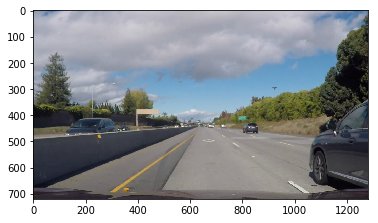

In [34]:
# use cv2.CAP_PROP_POS_MSEC to capture images at a given millisecond of the video
ms = 14500
vidcap = cv2.VideoCapture("challenge_video.mp4")
vidcap.set(cv2.CAP_PROP_POS_MSEC, ms)

# read in images
success,img = vidcap.read()
img_RGB = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)

# show images 
plt.imshow(img_RGB)
plt.show()

# write images to the test_images folder (commented when not in use)
#cv2.imwrite("test_images/from_challenge_video_"+np.str(ms)+"ms.jpg",img)